In [1]:
from notebook_util_mine import *
%matplotlib inline

In [2]:
from minee.data.mix_gaussian import MixedGaussian

## Data

In [6]:
np.random.seed(0)
sample_size = 200
rho1 = 0.8
data = MixedGaussian(n_samples=sample_size,rho1=rho1).data
data_t = torch.Tensor(data)

Separate X data and Y data for the estimation. This should be a preprocessing done before instead of after feeding the data to the model.

In [7]:
X = data[:,[0]]
Y = data[:,[1]]

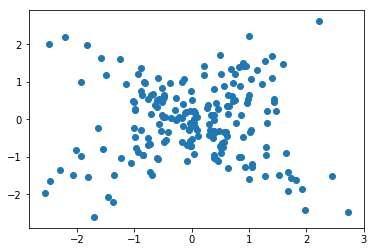

In [8]:
plt.scatter(X,Y)

Generate the reference samples by resampling.

In [9]:
X_ref = resample(X,batch_size=sample_size)
Y_ref = resample(Y,batch_size=sample_size)

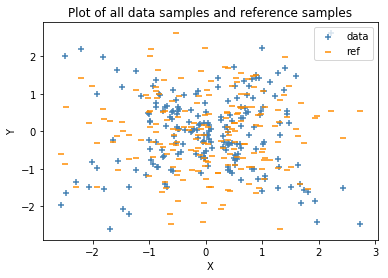

In [10]:
plt.scatter(X,Y,label="data",marker="+",color="steelblue")
plt.scatter(X_ref,Y_ref,label="ref",marker="_",color="darkorange")
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Plot of all data samples and reference samples')
plt.legend()

## MI estimation

### Choice of parameters

In [12]:
batch_size = int(sample_size*1)
lr = 1e-3
ma_rate = 0.1
fname = 'mix_gaussian_mine_full_batch_ma_rho8.pt' # file to load/save the results

### Initialization

In [13]:
XY_t = torch.Tensor(np.concatenate((X,Y),axis=1))
XY_ref_t = torch.Tensor(np.concatenate((X_ref,Y_ref),axis=1))

XY_net = Net(input_size=X.shape[1]+Y.shape[1],hidden_size=300)
XY_optimizer = optim.Adam(XY_net.parameters(),lr=lr)

ma_ef = 1 # for moving average

# For storing the results

XY_net_list = []
dXY_list = []

### Training
Automatically load previous results from db file if exists

In [14]:
if os.path.exists(fname):
    with open(fname,'rb') as f:
        checkpoint = torch.load(fname,map_location = "cuda" if torch.cuda.is_available() else "cpu")
        XY_net_list = checkpoint['XY_net_list']
        dXY_list = checkpoint['dXY_list']
        XY_net.load_state_dict(XY_net_list[-1])
        print('results loaded from '+fname)
else:
    for j in range(50):
        for i in range(200):
            XY_optimizer.zero_grad()
            batch_XY = resample(XY_t,batch_size=batch_size)
            batch_XY_ref = torch.Tensor(np.concatenate((resample(X,batch_size=batch_size), \
                                                        resample(Y,batch_size=batch_size)),axis=1))
            
            fXY = XY_net(batch_XY)
            efXY_ref = torch.exp(XY_net(batch_XY_ref))
            batch_dXY = torch.mean(fXY) - torch.log(torch.mean(efXY_ref))
            ma_ef = (1-ma_rate)*ma_ef + ma_rate*torch.mean(efXY_ref)
            batch_loss_XY = -(torch.mean(fXY) - (1/ma_ef.mean()).detach()*torch.mean(efXY_ref))
            batch_loss_XY.backward()
            XY_optimizer.step()    
            dXY_list = np.append(dXY_list, \
                                    (torch.mean(XY_net(XY_t)) \
                                     - torch.log(torch.mean(torch.exp(XY_net(XY_ref_t))))).cpu().item())
            
        XY_net_list = np.append(XY_net_list,copy.deepcopy(XY_net.state_dict()))

        # To save intermediate works, change the condition to True
        if True:
            with open(str(j)+fname,'wb') as f:
                dill.dump([XY_net_list,dXY_list],f)
                print('results saved: '+str(j))

results saved: 0
results saved: 1
results saved: 2
results saved: 3
results saved: 4
results saved: 5
results saved: 6
results saved: 7
results saved: 8
results saved: 9
results saved: 10
results saved: 11
results saved: 12
results saved: 13
results saved: 14
results saved: 15
results saved: 16
results saved: 17
results saved: 18
results saved: 19
results saved: 20
results saved: 21
results saved: 22
results saved: 23
results saved: 24
results saved: 25
results saved: 26
results saved: 27
results saved: 28
results saved: 29
results saved: 30
results saved: 31
results saved: 32
results saved: 33
results saved: 34
results saved: 35
results saved: 36
results saved: 37
results saved: 38
results saved: 39
results saved: 40
results saved: 41
results saved: 42
results saved: 43
results saved: 44
results saved: 45
results saved: 46
results saved: 47
results saved: 48
results saved: 49


To save new results to a db file using the following code, delete the existing db file.

In [15]:
if not os.path.exists(fname):
    with open(fname,'wb') as f:
        torch.save({
            'dXY_list' : dXY_list,
            'XY_net_list' : XY_net_list
        },f)
        #dill.dump([XY_net_list,X_net_list,Y_net_list,dXY_list,dX_list,dY_list],f)
        print('results saved to '+fname)

results saved to mix_gaussian_mine_full_batch_ma_rho8.pt


## Analysis

Text(0, 0.5, 'MI estimate')

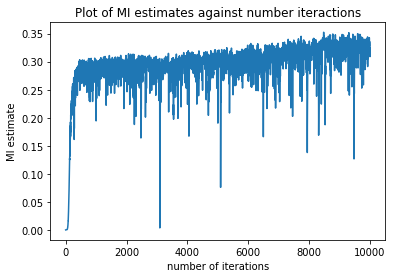

In [16]:
mi_list = dXY_list
plt.plot(mi_list)
plt.title("Plot of MI estimates against number iteractions")
plt.xlabel("number of iterations")
plt.ylabel("MI estimate")

In [17]:
XY_net_ = copy.deepcopy(XY_net)

In [18]:
T = mi_list.size # total number of iteractions
dt = T // XY_net_list.shape[0] # period for each snapshot of the NN
@interact(t=(dt,T,dt))
def f(t=T):
    plt.subplot(121)
    plt.plot(mi_list)
    plt.axvline(t)
    plt.subplot(122)
    XY_net_.load_state_dict(XY_net_list[(t // dt) - 1])
    plot_net_2(XY_net_)
    plt.show()

interactive(children=(IntSlider(value=10000, description='t', max=10000, min=200, step=200), Output()), _dom_c…

In [19]:
@interact(t=(100,T,100))
def f(t=T):
    w = 50
    plt.plot(mi_list,color='yellow')
    mi = mi_list[:t+1][-w:].mean()
    plt.axhline(mi)
    plt.axvline(t)
    print(mi)

interactive(children=(IntSlider(value=10000, description='t', max=10000, min=100, step=100), Output()), _dom_c…